In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 100, 100)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [10]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

2019.7794007598727

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 10000)

In [19]:
scaled_flattened_matrix.shape

(198, 10000)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [21]:
scaled_flattened_matrix.shape

(198, 10000)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 520000)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [33]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda


In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## Flattened Fully Connected Model

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))
   
timeDist = TimeDistributed(Flatten())(inputs)

Dense1 = Dense(50, kernel_initializer='glorot_normal', activation='relu')(timeDist)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_Fully_Connected")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


## Flattened LSTM Model

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

    
timeDist = TimeDistributed(Flatten())(inputs)

LSTM_layer1 = LSTM(100)(timeDist)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



## 2D CNN LSTM model

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
batch = 48
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(20, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(20, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])

LSTM_layer1 = LSTM(50)(merge)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



## 2D CNN with LSTM + Attention

In [ ]:
from tensorflow.keras import backend as K

In [37]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))
'''
cnn1 = Conv2D(10, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(10, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)
'''
'''
#Paralell 2D CNN layer
cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])
'''

#send both convolved layer and flattened layer into LSTM
timeDist3 = TimeDistributed(Flatten())(inputs)
#merge = concatenate([timeDist, timeDist3])

units = 100
LSTM_layer1 = LSTM(units, return_sequences=True)(timeDist3)
# compute importance for each step
attention = Dense(1, activation='tanh')(LSTM_layer1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

print("attention shape", attention.shape)
print("LSTM_layer1 shape", LSTM_layer1.shape)
sent_representation = Multiply()([LSTM_layer1, attention])

print("sent_representation shape", sent_representation.shape)
#same shape as LSTM output (None,52,100)

#For each timestep update a single weight on Dense layer
attended_LSTM_out = TimeDistributed(Dense(1, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_LSTM_out))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


attention shape (None, 52, 100)
LSTM_layer1 shape (None, 52, 100)
sent_representation shape (None, 52, 100)
Model: "2DCNN_LTSM_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 52, 10000)    0           input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 52, 100)      4040400     time_distributed_3[0][0]         
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 52, 1)        101         lstm[

## Attention on flattened inputs

In [125]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(50))(timeDist)
units = timeDist2.shape[2]
# compute importance for each step
attention = Dense(1, activation='tanh')(timeDist2)
print('attention.shape: ', attention.shape)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([timeDist2, attention])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(1, activation='relu'))(sent_representation)

timeDist3 = TimeDistributed(Flatten())(inputs)
timeDist4 = TimeDistributed(Dense(50))(timeDist3)
units = timeDist4.shape[2]
# compute importance for each step
attention2 = Dense(1, activation='tanh')(timeDist4)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation2 = Multiply()([timeDist4, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out2 = TimeDistributed(Dense(1, activation='relu'))(sent_representation2)
'''
timeDist5 = TimeDistributed(Flatten())(inputs)
timeDist6 = TimeDistributed(Dense(20))(timeDist5)
units = timeDist6.shape[2]
# compute importance for each step
attention3 = Dense(1, activation='tanh')(timeDist6)
attention3 = Flatten()(attention3)
attention3 = Activation('softmax')(attention3)
attention3 = RepeatVector(units)(attention3)
attention3 = Permute([2, 1])(attention3)
sent_representation3 = Multiply()([timeDist6, attention3])
#For each timestep update a single weight on Dense layer
attended_Dense_out3 = TimeDistributed(Dense(1, activation='relu'))(sent_representation3)
'''
merge = concatenate([attended_Dense_out, attended_Dense_out2])

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(merge))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_Time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


attention.shape:  (None, 52, 1)
Model: "Attention_Time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_78 (TimeDistri (None, 52, 10000)    0           input_15[0][0]                   
__________________________________________________________________________________________________
time_distributed_81 (TimeDistri (None, 52, 10000)    0           input_15[0][0]                   
__________________________________________________________________________________________________
time_distributed_79 (TimeDistri (None, 52, 50)       500050      time_distributed_78[0][0]        
_____________________________________________________

In [ ]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)



model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=7, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ]
                                   )
valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Train on 88 samples, validate on 28 samples
Epoch 1/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0081 - mae: 0.0081
Epoch 00001: val_loss improved from inf to 0.00792, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 1s 9ms/sample - loss: 0.0081 - mae: 0.0081 - val_loss: 0.0079 - val_mae: 0.0079
Epoch 2/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0078 - mae: 0.0078
Epoch 00002: val_loss improved from 0.00792 to 0.00761, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0078 - mae: 0.0078 - val_loss: 0.0076 - val_mae: 0.0076
Epoch 3/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0075 - mae: 0.

88/88 [==============================] - 0s 3ms/sample - loss: 0.0044 - mae: 0.0044 - val_loss: 0.0044 - val_mae: 0.0044
Epoch 20/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0043 - mae: 0.0043
Epoch 00020: val_loss improved from 0.00438 to 0.00427, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0043 - mae: 0.0043 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 21/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0041 - mae: 0.0041
Epoch 00021: val_loss improved from 0.00427 to 0.00416, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0041 - mae: 0.0041 - val_loss: 0.0042 - val_mae: 0.0042
Epo

88/88 [==============================] - 0s 3ms/sample - loss: 0.0028 - mae: 0.0028 - val_loss: 0.0029 - val_mae: 0.0029
Epoch 39/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0028 - mae: 0.0028
Epoch 00039: val_loss improved from 0.00289 to 0.00285, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0028 - mae: 0.0028 - val_loss: 0.0029 - val_mae: 0.0029
Epoch 40/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0028 - mae: 0.0028
Epoch 00040: val_loss improved from 0.00285 to 0.00281, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0027 - mae: 0.0027 - val_loss: 0.0028 - val_mae: 0.0028
Epo

88/88 [==============================] - 0s 2ms/sample - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 58/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0022 - mae: 0.0022
Epoch 00058: val_loss improved from 0.00231 to 0.00229, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 59/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0022 - mae: 0.0022
Epoch 00059: val_loss improved from 0.00229 to 0.00227, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0023 - val_mae: 0.0023
Epo

88/88 [==============================] - 0s 2ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021
Epoch 77/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0020 - mae: 0.0020
Epoch 00077: val_loss improved from 0.00207 to 0.00206, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021
Epoch 78/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0020 - mae: 0.0020
Epoch 00078: val_loss improved from 0.00206 to 0.00205, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021
Epo

88/88 [==============================] - 0s 3ms/sample - loss: 0.0019 - mae: 0.0019 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 97/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0019 - mae: 0.0019
Epoch 00097: val_loss did not improve from 0.00194
88/88 [==============================] - 0s 2ms/sample - loss: 0.0019 - mae: 0.0019 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 98/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0019 - mae: 0.0019
Epoch 00098: val_loss improved from 0.00194 to 0.00193, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0019 - mae: 0.0019 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 99/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00099: val_loss improved from 0.00193 to 0.00193, saving model to /home/zhimin9

Epoch 117/1000
49/88 [===============>..............] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00117: val_loss improved from 0.00188 to 0.00187, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 118/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00118: val_loss improved from 0.00187 to 0.00187, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200623-210215_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 119/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00119: val_loss improve

88/88 [==============================] - 0s 3ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 140/1000
77/88 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00140: val_loss did not improve from 0.00183
88/88 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018


### Best flatten() + LSTM(100) + Attention is at  MAE of 0.0016992822056636214

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [92]:
Predict = model.predict(X_valid)

In [93]:
Predict.shape

(28, 10000)

In [94]:
int(Predict[-1].shape[0]**(1/2)),int(Predict[-1].shape[0]**(1/2))

(100, 100)

In [95]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

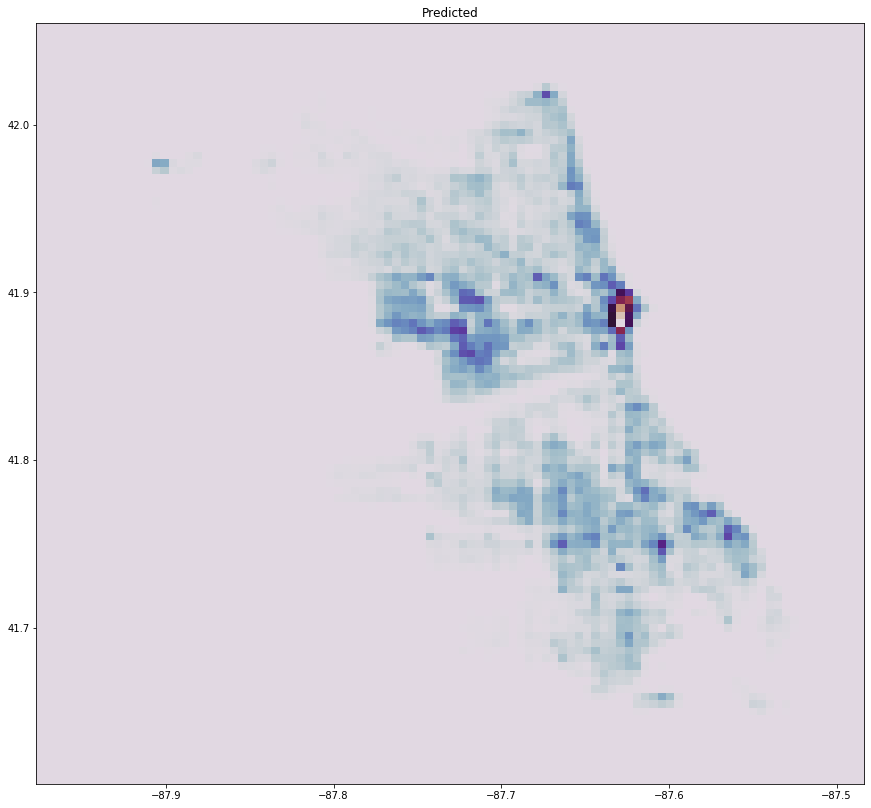

In [103]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
plt.figure(figsize=(18, 14))
plt.title('Predicted')
plt.imshow( X=reshapePred(Predict,1), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

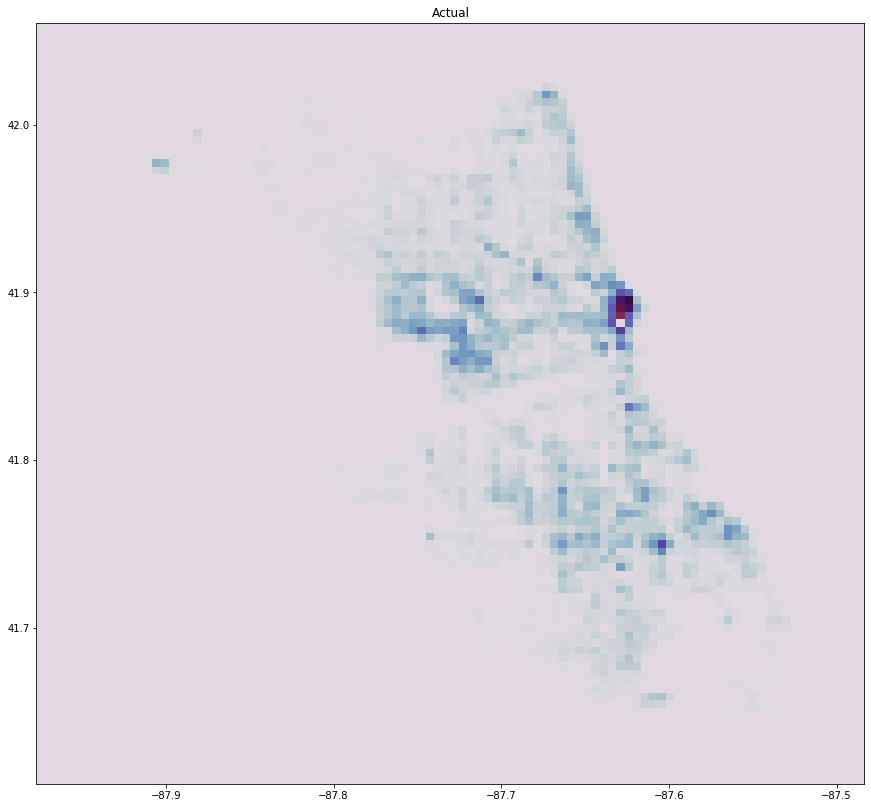

In [104]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=reshapePred(Y_valid,1), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

#### We plot the difference between prediction and target

In [120]:
diff = (reshapePred(Y_valid,3)-reshapePred(Predict,3))
diff.shape

(100, 100)

In [121]:
diff_max = np.max(diff)
diff_min = np.min(diff)
scaled_diff = (diff - diff_min)/(diff_max - diff_min)

In [122]:
np.max(scaled_diff)

1.0

In [123]:
diff

array([[-2.87253374e-06, -2.22320114e-06,  2.36268164e-07, ...,
        -2.36268164e-07, -2.87253374e-06,  2.36268164e-07],
       [ 2.02577121e-06,  2.36268164e-07,  2.36268164e-07, ...,
         2.87253374e-06,  2.22320114e-06, -2.36268164e-07],
       [ 2.87253374e-06, -2.36268164e-07, -2.22320114e-06, ...,
         2.22320114e-06,  2.22320114e-06, -2.36268164e-07],
       ...,
       [-2.36268164e-07,  2.02577121e-06,  2.36268164e-07, ...,
        -2.36268164e-07, -2.36268164e-07, -2.02577121e-06],
       [ 2.02577121e-06,  2.36268164e-07, -2.36268164e-07, ...,
         2.22320114e-06,  2.36268164e-07, -2.36268164e-07],
       [ 2.36268164e-07,  2.22320114e-06, -2.02577121e-06, ...,
         2.36268164e-07,  2.02576393e-06,  2.87253374e-06]])

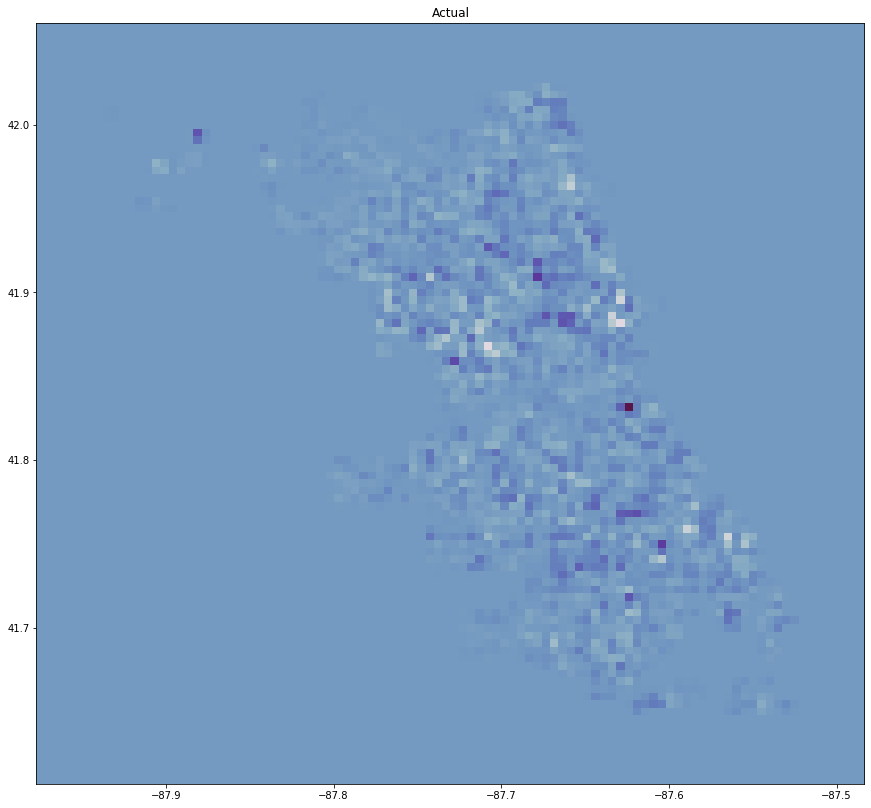

In [124]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=scaled_diff, cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

#### Note the differences is scaled, red means extreme differences inplot above. Interestingly we see the extreme differences is at the highest crime areas.